# Experiments for the Master's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed for the Master's Program in Business Informatics of the University of Mannheim

## 1. Imports and Graph Loading

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

G = nx.read_graphml("CourseSkillGraph_Master.graphml")

## 3. Experiments
### 3.1 Prerequisite Relationships

In [2]:
# Count amount of courses with prerequisites

courses_with_simple_prerequisite = []
courses_with_complex_prerequisite = []
courses_with_simple_exclusive_prerequiste = []
courses_with_complex_exclusive_prerequiste = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_complex_prerequisite:
                courses_with_complex_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_complex_exclusive_prerequiste:
                courses_with_complex_exclusive_prerequiste.append(node)

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_simple_prerequisite:
                courses_with_simple_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_simple_exclusive_prerequiste:
                courses_with_simple_exclusive_prerequiste.append(node)


print("Simple prerequisite relationships: " + str(courses_with_simple_prerequisite) + "\n")
print("Complex prerequisite relationships: " + str(courses_with_complex_prerequisite) + "\n")
print("Courses with simple exclusive prerequisite relationships: " + str(courses_with_simple_exclusive_prerequiste) + "\n")
print("Courses with complex exclusive prerequisite relationships: " + str(courses_with_complex_exclusive_prerequiste) + "\n")


print("Amount of courses with prerequisite: " + str(len(courses_with_simple_prerequisite) + len(courses_with_complex_prerequisite)))


Simple prerequisite relationships: ['FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation)', 'FIN 605 Applied Portfolio Management', 'FIN 640 Corporate Finance II (Mergers, Acquisitions and Divestitures)', 'IS 513 Applied IT Management in the Digital Age', 'IS 613 Applied Project in Design Thinking and Lean Software Development', 'MKT 664 Brand Strategy Seminar', 'OPM 662 Business Analytics: Modeling and Optimization']

Complex prerequisite relationships: ['ACC 620 Accounting for Financial Instruments and Financial Institutions', 'ACC 626 Transaction Accounting', 'ACC 628 Selected Issues in IFRS Accounting', 'ACC 632 Konzernrechnungslegungspraxis', 'ACC 662 Private Equity: Due Diligence and Value Creation', 'ACC 670 Audit Theory', 'ACC 676 Case Studies on Consulting in Financial Services Firms', 'ACC 680 Disclosure Theory', 'FIN 620 Behavioral Finance', 'FIN 685 Topics in Financial Regulation', 'FIN 686 Topics in Sustainable Finance', 'IS 607 Digit

In [3]:
# Count number of courses

course_amount = 0
for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        course_amount += 1

print("Amount of courses: " + str(course_amount) + "\n")

Amount of courses: 171



In [4]:
# Calculate blocking paths

starting_nodes = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        is_starting_node = True
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" or G.nodes[edge[0]].get("type") == "prerequisite":
                is_starting_node = False
                break
        if is_starting_node:
            starting_nodes.append([[node]])

starting_nodes_copy = starting_nodes.copy()
blocking_paths = []

while starting_nodes_copy:
    finished_paths = []
    for i in range(0, len(starting_nodes_copy)):
        dim = len(starting_nodes_copy[i]) - 1 
        outgoing_edges = G.out_edges(starting_nodes_copy[i][dim])
        is_finished = True
        new_dim = []
        for edge in outgoing_edges:
            if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or G.nodes[edge[1]].get("type") == "prerequisite":
                is_finished = False
                new_dim.append(edge[1])
        if is_finished:
            finished_paths.append(i)
        else:
            starting_nodes_copy[i].append(new_dim)
    for finished_path in reversed(finished_paths):
        blocking_paths.append(starting_nodes_copy[finished_path])
        starting_nodes_copy.pop(finished_path)

blocking_paths_filtered = []

for blocking_path in blocking_paths:
    if len(blocking_path) > 1:
        blocking_paths_filtered.append(blocking_path)
        
for blocking_path in blocking_paths_filtered:
    print("Path:")
    print(blocking_path)

Path:
[['MKT 663 Branding and Brand Management'], ['MKT 664 Brand Strategy Seminar']]
Path:
[['OPM 591 Strategic Procurement'], ['MIN 10', 'MIN 11', 'MIN 12'], ['OPM 601 Supply Chain Management', 'OPM 661 Business Analytics: Robust Planning in Stochastic Systems', 'OPM 682 Revenue Management']]
Path:
[['OPM 582 Case Studies in Service Operations Management'], ['MIN 10', 'MIN 11', 'MIN 12'], ['OPM 601 Supply Chain Management', 'OPM 661 Business Analytics: Robust Planning in Stochastic Systems', 'OPM 682 Revenue Management']]
Path:
[['OPM 581 Service Operations Management'], ['MIN 10', 'MIN 11', 'MIN 12'], ['OPM 601 Supply Chain Management', 'OPM 661 Business Analytics: Robust Planning in Stochastic Systems', 'OPM 682 Revenue Management']]
Path:
[['OPM 561 Production Management: Lean Approaches and Variability'], ['MIN 10', 'MIN 11', 'OPM 662 Business Analytics: Modeling and Optimization', 'MIN 12'], ['OPM 601 Supply Chain Management', 'OPM 661 Business Analytics: Robust Planning in Stoc

In [5]:
#Calculate depth of prerequisite paths

paths_finished = []

for blocking_path in blocking_paths:
    starting_node = blocking_path[0][0]
    paths = [[starting_node]]
    is_finished = False
    while not is_finished:
        is_finished = True
        paths_to_delete = []
        for path in paths:
            path_is_finished = True
            last_node = path[len(path) - 1]
            outgoing_edges = G.out_edges(last_node)
            for edge in outgoing_edges:
                    if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or (G.nodes[edge[1]].get("type") == "prerequisite"): #and 
                    #G.nodes[edge[1]].get("subtype") == "MIN"):
                        path_is_finished = False
                        new_path = path.copy()
                        new_path.append(edge[1])
                        if path not in paths_to_delete:
                            paths_to_delete.append(path)
            if path_is_finished:
                paths_to_delete.append(path)
                paths_finished.append(path)
            else:
                paths.append(new_path)
                is_finished = False
        for path_to_delete in paths_to_delete:
            paths.remove(path_to_delete)

for path in paths_finished:
    depth = 0
    for course in path:
        if G.nodes[course].get("type") == "course":
            depth += 1
    path.append(depth)

depth_2 = 0
depth_3 = 0

for path in paths_finished:
    if path[len(path) - 1] == 2:
        depth_2 += 1
    if path[len(path) - 1] == 3:
        depth_3 += 1
        print(path)

print("Depth 2: " + str(depth_2))
print("Depth 3: " + str(depth_3))

['FIN 590 Financial Institutions I', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 580 Derivatives I – Basic Strategies and Pricing', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 561 Investmentmanagement von Versicherungsunternehmen', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 560 Risikomanagement von Versicherungsunternehmen', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 542 Quantitative Corporate Finance for Researchers', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 500 Investments', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5', 'FIN 620 Behavioral Finance', 3]
['FIN 540 Corporate Finance I - Lecture (Capital Structure, Cost of Capital and Valuation)', 'MIN 7', 'FIN 686 Topics in Sustainable Finance', 'MIN 5',

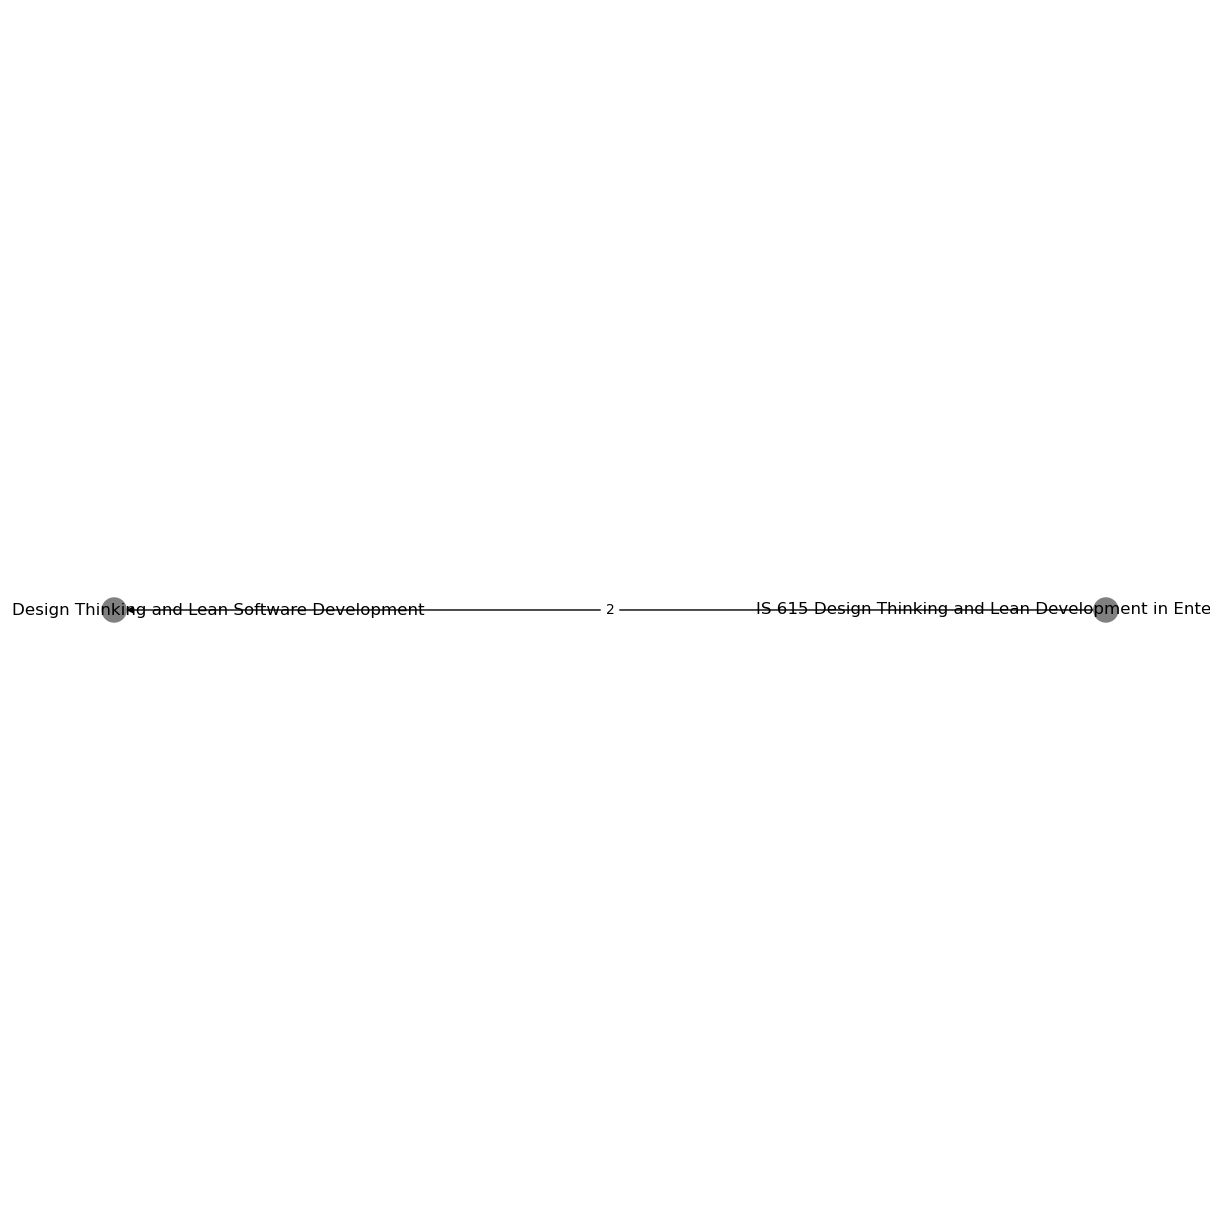

In [6]:
# Script for visualization

# Choose node
node_id = 'IS 613 Applied Project in Design Thinking and Lean Software Development'
#node_id = 'CS 308 Softwaretechnik I Software Engineering I'

# Get relevant edges
incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") == "course" or G.nodes[n].get("type") == "prerequisite"]
#outgoing_nodes = [n for n in G.successors(node_id)]

# Combine relevant edges and create subgraph
#subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
subgraph_nodes = set([node_id] + incoming_nodes)

subgraph = G.subgraph(subgraph_nodes)

# Create layout for subgraph
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Draw subgraph
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

# Add labels
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

## 3.2 Hubs & Bridges

In [7]:
# Calculate number of outgoing and ingoing skills

incoming_skills = []
outgoing_skills = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        count = 0
        weight = 0
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        incoming_skills.append([node, count, weight])
        
        outgoing_edges = G.out_edges(node)
        count = 0
        weight = 0
        for edge in outgoing_edges:
            if G.nodes[edge[1]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        outgoing_skills.append([node,count, weight])

In [8]:
# Get courses with the most highest number / weights for ingoing and outcoming skills

# Ingoing
incoming_skills_counts = [x[1] for x in incoming_skills]
incoming_skills_weights = [x[2] for x in incoming_skills]

incoming_skills_counts_avg = sum(incoming_skills_counts) / len(incoming_skills_counts)
incoming_skills_weights_avg = sum(incoming_skills_weights) / len(incoming_skills_counts)

incoming_skills_counts_sorted = sorted(incoming_skills, key=lambda x: x[1], reverse = True)
incoming_skills_weights_sorted = sorted(incoming_skills, key=lambda x: x[2], reverse = True)

# Outgoing
outgoing_skills_counts = [x[1] for x in outgoing_skills]
outgoing_skills_weights = [x[2] for x in outgoing_skills]

outgoing_skills_counts_avg = sum(outgoing_skills_counts) / len(outgoing_skills_counts)
outgoing_skills_weights_avg = sum(outgoing_skills_weights) / len(outgoing_skills_counts)

outgoing_skills_counts_sorted = sorted(outgoing_skills, key=lambda x: x[1], reverse = True)
outgoing_skills_weights_sorted = sorted(outgoing_skills, key=lambda x: x[2], reverse = True)

print("Average incoming skills number: " + str(incoming_skills_counts_avg))
print("Most incoming skills:")
for i in range(0, 15):
    print(incoming_skills_counts_sorted[i])

print("\nAverage outgoing skill number: " + str(outgoing_skills_counts_avg))
print("Most outgoing skills:")
for i in range(0, 10):
    print(outgoing_skills_counts_sorted[i])

print("\nAverage incoming skill weight: " + str(incoming_skills_weights_avg))
print("Highest incoming skill weights:")
for i in range(0, 15):
    print(incoming_skills_weights_sorted[i])

print("\nAverage outgoing skills: " + str(outgoing_skills_weights_avg))
print("Highest outgoing skill weights:")
for i in range(0, 10):
    print(outgoing_skills_weights_sorted[i])

Average incoming skills number: 1.4035087719298245
Most incoming skills:
['CS 704 Master Seminar Artificial Intelligence', 6, 1.1728769909333132]
['CS 530 Database Systems II (DBSII)', 5, 0.19028500929747816]
['CS 550 Algorithmics', 5, 0.03257642783749695]
['IE 500 Data Mining I', 5, 0.0412257052590317]
['IE 672 Data Mining II', 5, 0.9974907228349376]
['IE 684 Web Mining Project', 5, 0.6834123699064788]
['CS 701 Selected Topics in Algorithmics and Cryptography', 5, 1.7025165739843564]
['CS 709 Seminar Text Analytics', 5, 1.6432537652558334]
['FIN 542 Quantitative Corporate Finance for Researchers', 5, 0.0]
['CS 560 Large-Scale Data Management', 4, 0.2770293311546293]
['CS 652 Data Security', 4, 0.0534781450859825]
['IE 630 Query Optimization', 4, 1.068283820139257]
['IS 613 Applied Project in Design Thinking and Lean Software Development', 4, 0.11451969011634294]
['CS 605 GPU Programming', 3, 0.1836517857142857]
['CS 646 Higher Level Computer Vision', 3, 0.02241030271522514]

Average o

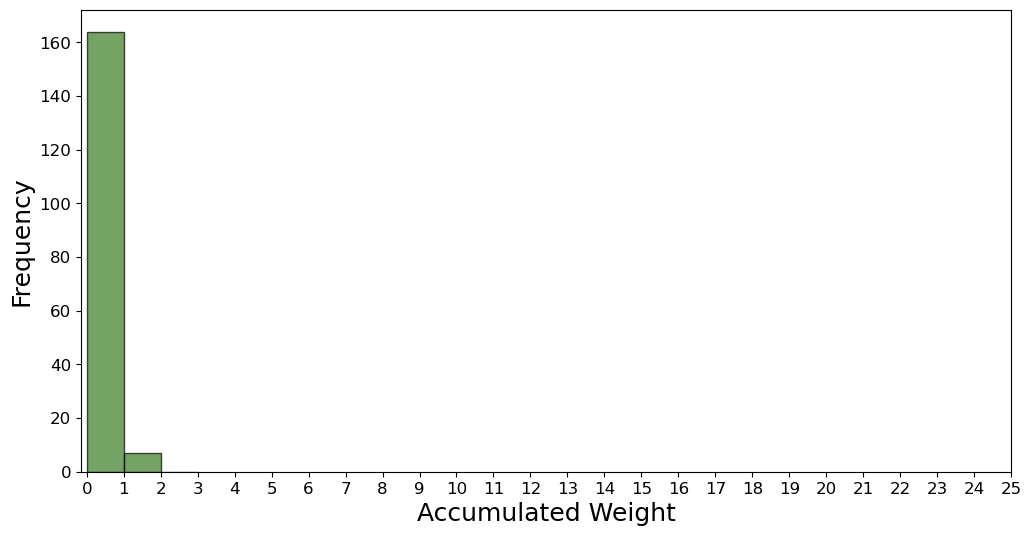

In [9]:
plt.figure(figsize=(12, 6))

bins = np.arange(min(incoming_skills_weights), max(incoming_skills_weights) + 2)
frequencies, bin_edges = np.histogram(incoming_skills_weights, bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], frequencies, width=1, align='edge', color='#3B7D23', edgecolor='black', alpha=0.7)

plt.xlabel('Accumulated Weight', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(np.arange(0,26))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('AccumulatedIncomingSkillWeights_Master.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()

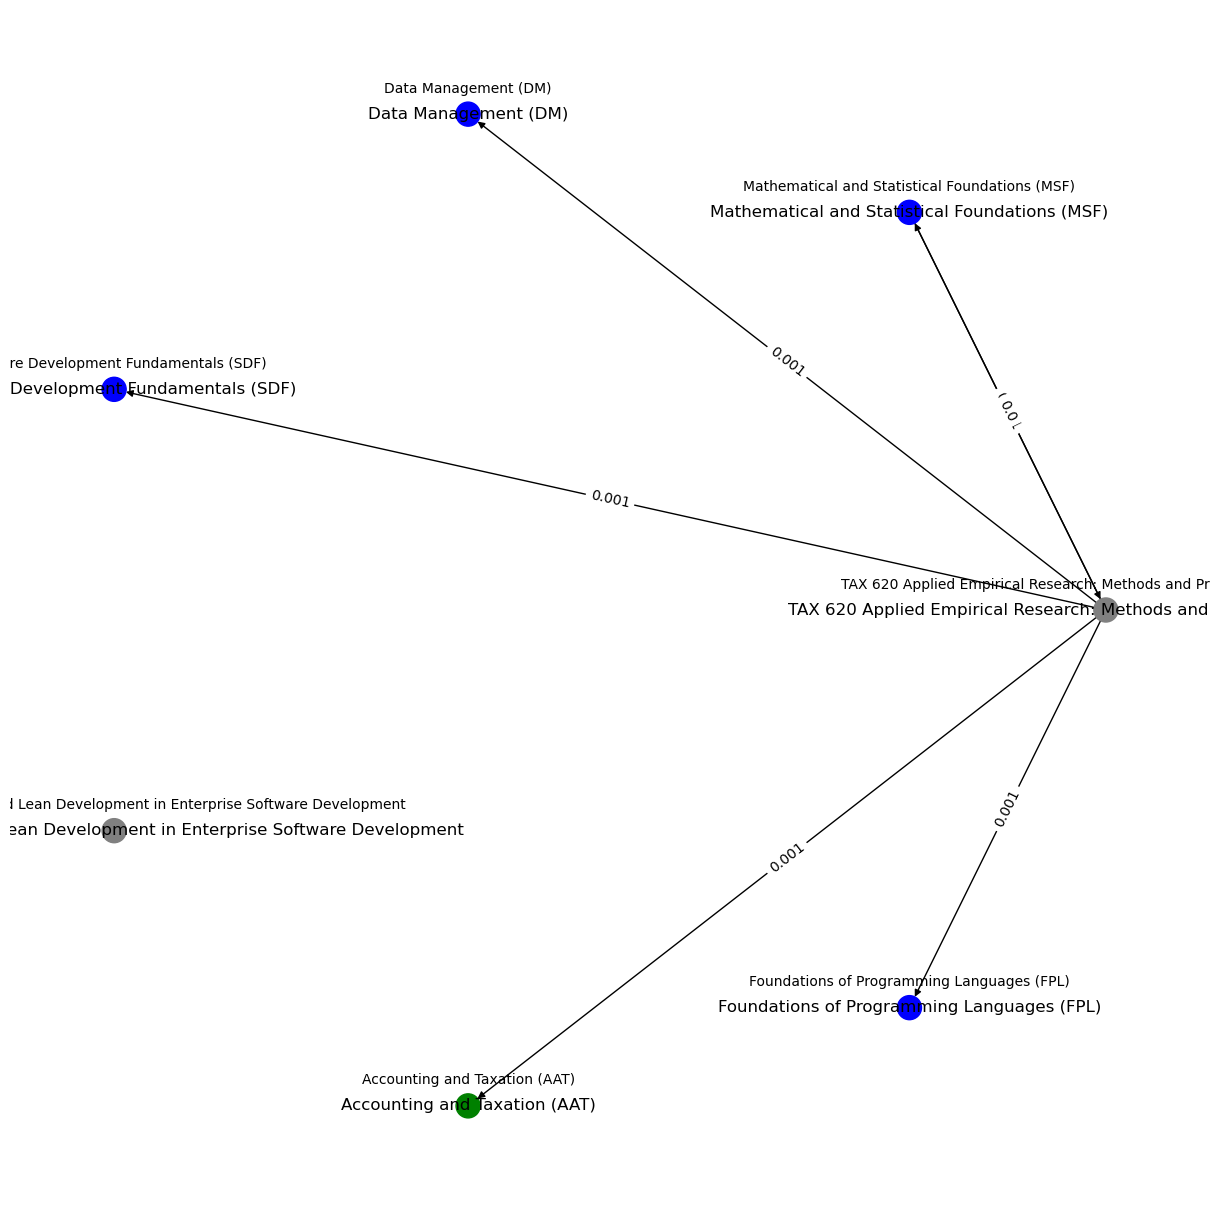

In [10]:
# Script for visualization

# Choose node
node_id = 'TAX 620 Applied Empirical Research: Methods and Practical Implementation'
#node_id = 'CS 308 Softwaretechnik I Software Engineering I'

# Get relevant edges
#incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") == "course" or G.nodes[n].get("type") == "prerequisite"]
outgoing_nodes = [n for n in G.successors(node_id)]

# Combine relevant edges and create subgraph
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

subgraph = G.subgraph(subgraph_nodes)

# Create layout for subgraph
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Draw subgraph
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

# Add labels
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

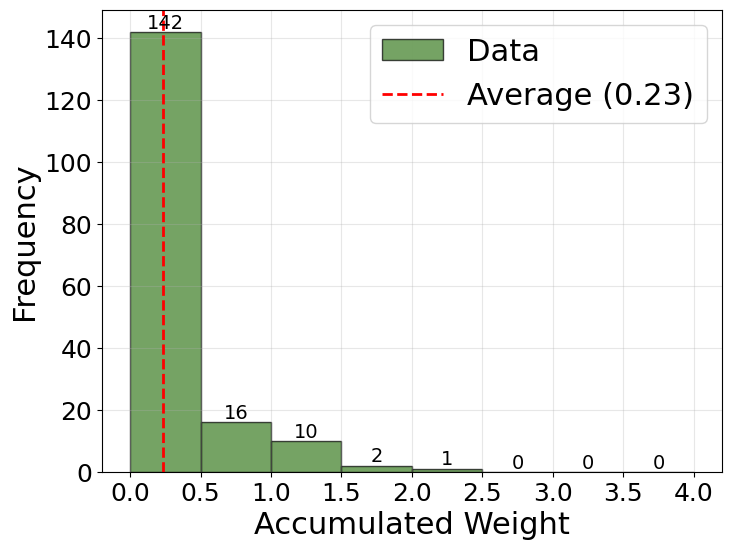

In [11]:
# Create Histogramms
plt.figure(figsize=(8, 6))
bins = np.linspace(0, 4, 9)
counts, bin_edges, bars = plt.hist(outgoing_skills_weights, bins=bins, color='#3B7D23', edgecolor='black', alpha=0.7, label='Data')

# Add average
plt.axvline(outgoing_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({outgoing_skills_weights_avg:.2f})')

# Add Counts above bars
for count, edge in zip(counts, bin_edges[:-1]): 
    plt.text(edge + (bin_edges[1] - bin_edges[0]) / 2, count + 1.1, f'{int(count)}', ha='center', fontsize=14)

# Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)

# Show and export
plt.savefig('HistogramAccumulatedOutgoingEdges_Master.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()